## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 32
CROP_SIZE = 256
Z_START = 24
Z_DIMS = 16
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

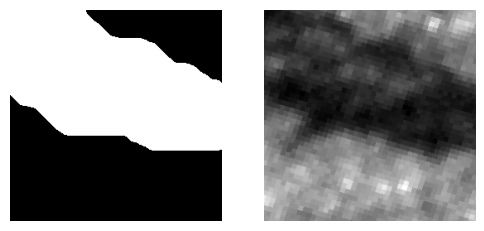

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4093

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
                for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, 0]
                    if np.sum(surface) / (CROP_SIZE * CROP_SIZE) > 0.2:
                        self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(CROP_SIZE * 0.1), 
                                mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                A.OneOf([
                        A.GaussNoise(var_limit=[0.01, 0.05]),
                        A.GaussianBlur(blur_limit=(3, 5), sigma_limit=0),
                        A.MotionBlur(blur_limit=3),
                        ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.1, p=0.5),
                A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
                # A.Cutout(max_h_size=int(CROP_SIZE * 0.2),
                #          max_w_size=int(CROP_SIZE * 0.2), num_holes=1, p=1.0),
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-128 if x1 != 0 else 0, 128)
        y_offset = random.randint(-128 if y1 != 0 else 0, 128)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + CROP_SIZE
        y2 = y1 + CROP_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        
        
        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0) 
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
            for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
                self.xys.append((x, y))
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+CROP_SIZE, y1+CROP_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        frag_crop = frag_crop/65535.0
        # frag_crop = (frag_crop - 0.45)/0.225
        
        mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
i=30
img = dataset_train[i][0]
img.min(), img.max()

(tensor(0.0157, dtype=torch.float64), tensor(1., dtype=torch.float64))

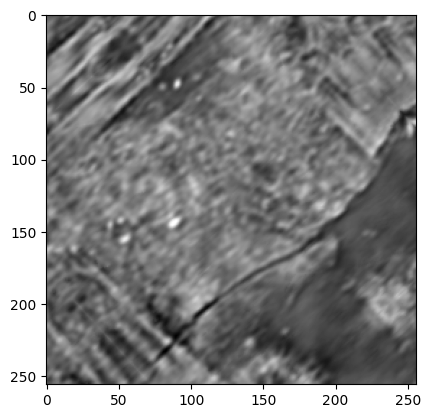

In [13]:
img_2 = img.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img_2[:, :, 0], cmap="gray")

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [14]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [15]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [16]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [17]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [18]:
scaler = amp.GradScaler()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=10, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [19]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [20]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [21]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/50  Mem : 14GB  LR : 4.00E-06  Loss: 0.7377: 100%|██████████| 62/62 [00:43<00:00,  1.42it/s]                                                                                                                                                                                 
Val Loss: 0.6949: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.133235
Threshold : 0.25	FBeta : 0.133554
Threshold : 0.30	FBeta : 0.134138
Threshold : 0.35	FBeta : 0.138940
Threshold : 0.40	FBeta : 0.156246
Threshold : 0.45	FBeta : 0.170577
Threshold : 0.50	FBeta : 0.182187
Threshold : 0.55	FBeta : 0.182607
Threshold : 0.60	FBeta : 0.132345
Threshold : 0.65	FBeta : 0.036453
Threshold : 0.70	FBeta : 0.001594
Threshold : 0.75	FBeta : 0.000013
Threshold : 0.80	FBeta : 0.000000



Epoch 2/50  Mem : 18.5GB  LR : 1.81E-05  Loss: 0.6292: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                               
Val Loss: 0.6084: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]                                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.133346
Threshold : 0.25	FBeta : 0.135992
Threshold : 0.30	FBeta : 0.143912
Threshold : 0.35	FBeta : 0.158762
Threshold : 0.40	FBeta : 0.170308
Threshold : 0.45	FBeta : 0.154638
Threshold : 0.50	FBeta : 0.086731
Threshold : 0.55	FBeta : 0.014893
Threshold : 0.60	FBeta : 0.000169
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 3/50  Mem : 18.5GB  LR : 5.20E-05  Loss: 0.5542: 100%|██████████| 62/62 [00:41<00:00,  1.48it/s]                                                                                                                                                                               
Val Loss: 0.4470: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.148070
Threshold : 0.25	FBeta : 0.185284
Threshold : 0.30	FBeta : 0.215025
Threshold : 0.35	FBeta : 0.239873
Threshold : 0.40	FBeta : 0.292429
Threshold : 0.45	FBeta : 0.353480
Threshold : 0.50	FBeta : 0.364554
Threshold : 0.55	FBeta : 0.310328
Threshold : 0.60	FBeta : 0.037372
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 4/50  Mem : 18.5GB  LR : 8.59E-05  Loss: 0.5113: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]                                                                                                                                                                               
Val Loss: 0.3946: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]                                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.197227
Threshold : 0.25	FBeta : 0.218096
Threshold : 0.30	FBeta : 0.232681
Threshold : 0.35	FBeta : 0.288317
Threshold : 0.40	FBeta : 0.339473
Threshold : 0.45	FBeta : 0.360701
Threshold : 0.50	FBeta : 0.349907
Threshold : 0.55	FBeta : 0.306283
Threshold : 0.60	FBeta : 0.061577
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 5/50  Mem : 18.5GB  LR : 1.00E-04  Loss: 0.4746: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]                                                                                                                                                                               
Val Loss: 0.3745: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.211294
Threshold : 0.25	FBeta : 0.253207
Threshold : 0.30	FBeta : 0.320017
Threshold : 0.35	FBeta : 0.355339
Threshold : 0.40	FBeta : 0.368840
Threshold : 0.45	FBeta : 0.373190
Threshold : 0.50	FBeta : 0.371044
Threshold : 0.55	FBeta : 0.358092
Threshold : 0.60	FBeta : 0.319669
Threshold : 0.65	FBeta : 0.185368
Threshold : 0.70	FBeta : 0.062784
Threshold : 0.75	FBeta : 0.008777
Threshold : 0.80	FBeta : 0.000000



Epoch 6/50  Mem : 18.5GB  LR : 9.99E-05  Loss: 0.4492: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]                                                                                                                                                                               
Val Loss: 0.4308: 100%|██████████| 24/24 [00:05<00:00,  4.10it/s]                                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.211905
Threshold : 0.25	FBeta : 0.247577
Threshold : 0.30	FBeta : 0.287846
Threshold : 0.35	FBeta : 0.290445
Threshold : 0.40	FBeta : 0.281834
Threshold : 0.45	FBeta : 0.267129
Threshold : 0.50	FBeta : 0.242790
Threshold : 0.55	FBeta : 0.203358
Threshold : 0.60	FBeta : 0.124116
Threshold : 0.65	FBeta : 0.038505
Threshold : 0.70	FBeta : 0.008622
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 7/50  Mem : 18.5GB  LR : 9.95E-05  Loss: 0.4257: 100%|██████████| 62/62 [00:41<00:00,  1.49it/s]                                                                                                                                                                               
Val Loss: 0.3229: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                    

Threshold : 0.20	FBeta : 0.290571
Threshold : 0.25	FBeta : 0.327010
Threshold : 0.30	FBeta : 0.335966
Threshold : 0.35	FBeta : 0.338917
Threshold : 0.40	FBeta : 0.331427
Threshold : 0.45	FBeta : 0.317205
Threshold : 0.50	FBeta : 0.297317
Threshold : 0.55	FBeta : 0.244215
Threshold : 0.60	FBeta : 0.144693
Threshold : 0.65	FBeta : 0.062526
Threshold : 0.70	FBeta : 0.026490
Threshold : 0.75	FBeta : 0.003657
Threshold : 0.80	FBeta : 0.000000




Epoch 8/50  Mem : 18.5GB  LR : 9.89E-05  Loss: 0.4084: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                               
Val Loss: 0.4228: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.219875
Threshold : 0.25	FBeta : 0.257017
Threshold : 0.30	FBeta : 0.286709
Threshold : 0.35	FBeta : 0.311188
Threshold : 0.40	FBeta : 0.326263
Threshold : 0.45	FBeta : 0.340141
Threshold : 0.50	FBeta : 0.354975
Threshold : 0.55	FBeta : 0.371994
Threshold : 0.60	FBeta : 0.392520
Threshold : 0.65	FBeta : 0.413038
Threshold : 0.70	FBeta : 0.431989
Threshold : 0.75	FBeta : 0.431172
Threshold : 0.80	FBeta : 0.403522



Epoch 9/50  Mem : 18.5GB  LR : 9.81E-05  Loss: 0.4000: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                               
Val Loss: 0.3039: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.323724
Threshold : 0.25	FBeta : 0.371783
Threshold : 0.30	FBeta : 0.400212
Threshold : 0.35	FBeta : 0.417199
Threshold : 0.40	FBeta : 0.427750
Threshold : 0.45	FBeta : 0.434191
Threshold : 0.50	FBeta : 0.437985
Threshold : 0.55	FBeta : 0.439253
Threshold : 0.60	FBeta : 0.436581
Threshold : 0.65	FBeta : 0.428321
Threshold : 0.70	FBeta : 0.402092
Threshold : 0.75	FBeta : 0.360588
Threshold : 0.80	FBeta : 0.307002



Epoch 10/50  Mem : 18.5GB  LR : 9.70E-05  Loss: 0.3839: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.4085: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.290038
Threshold : 0.25	FBeta : 0.317605
Threshold : 0.30	FBeta : 0.315400
Threshold : 0.35	FBeta : 0.298279
Threshold : 0.40	FBeta : 0.264256
Threshold : 0.45	FBeta : 0.228008
Threshold : 0.50	FBeta : 0.194497
Threshold : 0.55	FBeta : 0.159992
Threshold : 0.60	FBeta : 0.122769
Threshold : 0.65	FBeta : 0.082052
Threshold : 0.70	FBeta : 0.045089
Threshold : 0.75	FBeta : 0.023489
Threshold : 0.80	FBeta : 0.012608



Epoch 11/50  Mem : 18.5GB  LR : 9.57E-05  Loss: 0.3721: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]                                                                                                                                                                              
Val Loss: 0.3600: 100%|██████████| 24/24 [00:05<00:00,  4.09it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.269314
Threshold : 0.25	FBeta : 0.291390
Threshold : 0.30	FBeta : 0.309203
Threshold : 0.35	FBeta : 0.326812
Threshold : 0.40	FBeta : 0.344784
Threshold : 0.45	FBeta : 0.365216
Threshold : 0.50	FBeta : 0.387154
Threshold : 0.55	FBeta : 0.405307
Threshold : 0.60	FBeta : 0.416437
Threshold : 0.65	FBeta : 0.414911
Threshold : 0.70	FBeta : 0.401851
Threshold : 0.75	FBeta : 0.372789
Threshold : 0.80	FBeta : 0.324471



Epoch 12/50  Mem : 18.5GB  LR : 9.41E-05  Loss: 0.3638: 100%|██████████| 62/62 [00:43<00:00,  1.43it/s]                                                                                                                                                                              
Val Loss: 0.2704: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.426584
Threshold : 0.25	FBeta : 0.468902
Threshold : 0.30	FBeta : 0.493151
Threshold : 0.35	FBeta : 0.503507
Threshold : 0.40	FBeta : 0.505104
Threshold : 0.45	FBeta : 0.500543
Threshold : 0.50	FBeta : 0.487089
Threshold : 0.55	FBeta : 0.465472
Threshold : 0.60	FBeta : 0.424579
Threshold : 0.65	FBeta : 0.370675
Threshold : 0.70	FBeta : 0.307556
Threshold : 0.75	FBeta : 0.237773
Threshold : 0.80	FBeta : 0.163614



Epoch 13/50  Mem : 18.5GB  LR : 9.24E-05  Loss: 0.3590: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.7140: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.240803
Threshold : 0.25	FBeta : 0.246148
Threshold : 0.30	FBeta : 0.248745
Threshold : 0.35	FBeta : 0.251893
Threshold : 0.40	FBeta : 0.255620
Threshold : 0.45	FBeta : 0.259531
Threshold : 0.50	FBeta : 0.263873
Threshold : 0.55	FBeta : 0.268734
Threshold : 0.60	FBeta : 0.274653
Threshold : 0.65	FBeta : 0.282316
Threshold : 0.70	FBeta : 0.292001
Threshold : 0.75	FBeta : 0.305464
Threshold : 0.80	FBeta : 0.320263



Epoch 14/50  Mem : 18.5GB  LR : 9.05E-05  Loss: 0.3540: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                              
Val Loss: 0.3461: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.290661
Threshold : 0.25	FBeta : 0.300673
Threshold : 0.30	FBeta : 0.311352
Threshold : 0.35	FBeta : 0.321436
Threshold : 0.40	FBeta : 0.333027
Threshold : 0.45	FBeta : 0.343514
Threshold : 0.50	FBeta : 0.353046
Threshold : 0.55	FBeta : 0.361120
Threshold : 0.60	FBeta : 0.368452
Threshold : 0.65	FBeta : 0.373604
Threshold : 0.70	FBeta : 0.371011
Threshold : 0.75	FBeta : 0.359672
Threshold : 0.80	FBeta : 0.335812



Epoch 15/50  Mem : 18.5GB  LR : 8.83E-05  Loss: 0.3516: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]                                                                                                                                                                              
Val Loss: 0.2650: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.418402
Threshold : 0.25	FBeta : 0.434261
Threshold : 0.30	FBeta : 0.446016
Threshold : 0.35	FBeta : 0.452026
Threshold : 0.40	FBeta : 0.458288
Threshold : 0.45	FBeta : 0.462513
Threshold : 0.50	FBeta : 0.459799
Threshold : 0.55	FBeta : 0.443063
Threshold : 0.60	FBeta : 0.410881
Threshold : 0.65	FBeta : 0.365756
Threshold : 0.70	FBeta : 0.319615
Threshold : 0.75	FBeta : 0.261171
Threshold : 0.80	FBeta : 0.187351



Epoch 16/50  Mem : 18.5GB  LR : 8.60E-05  Loss: 0.3367: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                              
Val Loss: 0.2653: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.487439
Threshold : 0.25	FBeta : 0.508453
Threshold : 0.30	FBeta : 0.504332
Threshold : 0.35	FBeta : 0.487537
Threshold : 0.40	FBeta : 0.466298
Threshold : 0.45	FBeta : 0.438939
Threshold : 0.50	FBeta : 0.408356
Threshold : 0.55	FBeta : 0.370932
Threshold : 0.60	FBeta : 0.327641
Threshold : 0.65	FBeta : 0.280178
Threshold : 0.70	FBeta : 0.232606
Threshold : 0.75	FBeta : 0.177440
Threshold : 0.80	FBeta : 0.115863



Epoch 17/50  Mem : 18.5GB  LR : 8.35E-05  Loss: 0.3299: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]                                                                                                                                                                              
Val Loss: 0.2615: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.446442
Threshold : 0.25	FBeta : 0.464684
Threshold : 0.30	FBeta : 0.473059
Threshold : 0.35	FBeta : 0.471997
Threshold : 0.40	FBeta : 0.466934
Threshold : 0.45	FBeta : 0.455162
Threshold : 0.50	FBeta : 0.438056
Threshold : 0.55	FBeta : 0.413352
Threshold : 0.60	FBeta : 0.379001
Threshold : 0.65	FBeta : 0.334124
Threshold : 0.70	FBeta : 0.284120
Threshold : 0.75	FBeta : 0.231031
Threshold : 0.80	FBeta : 0.173240



Epoch 18/50  Mem : 18.5GB  LR : 8.08E-05  Loss: 0.3279: 100%|██████████| 62/62 [00:41<00:00,  1.48it/s]                                                                                                                                                                              
Val Loss: 0.2556: 100%|██████████| 24/24 [00:05<00:00,  4.09it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.387884
Threshold : 0.25	FBeta : 0.410116
Threshold : 0.30	FBeta : 0.425393
Threshold : 0.35	FBeta : 0.436938
Threshold : 0.40	FBeta : 0.445071
Threshold : 0.45	FBeta : 0.452364
Threshold : 0.50	FBeta : 0.457858
Threshold : 0.55	FBeta : 0.453267
Threshold : 0.60	FBeta : 0.436356
Threshold : 0.65	FBeta : 0.400532
Threshold : 0.70	FBeta : 0.347839
Threshold : 0.75	FBeta : 0.268312
Threshold : 0.80	FBeta : 0.175446



Epoch 19/50  Mem : 18.5GB  LR : 7.80E-05  Loss: 0.3354: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                              
Val Loss: 0.2842: 100%|██████████| 24/24 [00:05<00:00,  4.09it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.420760
Threshold : 0.25	FBeta : 0.420184
Threshold : 0.30	FBeta : 0.406831
Threshold : 0.35	FBeta : 0.392166
Threshold : 0.40	FBeta : 0.375374
Threshold : 0.45	FBeta : 0.356062
Threshold : 0.50	FBeta : 0.336194
Threshold : 0.55	FBeta : 0.313408
Threshold : 0.60	FBeta : 0.286791
Threshold : 0.65	FBeta : 0.251037
Threshold : 0.70	FBeta : 0.211423
Threshold : 0.75	FBeta : 0.170794
Threshold : 0.80	FBeta : 0.126703



Epoch 20/50  Mem : 18.5GB  LR : 7.50E-05  Loss: 0.3170: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.3903: 100%|██████████| 24/24 [00:05<00:00,  4.09it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.272358
Threshold : 0.25	FBeta : 0.286420
Threshold : 0.30	FBeta : 0.298949
Threshold : 0.35	FBeta : 0.311231
Threshold : 0.40	FBeta : 0.325340
Threshold : 0.45	FBeta : 0.341119
Threshold : 0.50	FBeta : 0.356101
Threshold : 0.55	FBeta : 0.371985
Threshold : 0.60	FBeta : 0.389654
Threshold : 0.65	FBeta : 0.409015
Threshold : 0.70	FBeta : 0.430271
Threshold : 0.75	FBeta : 0.448417
Threshold : 0.80	FBeta : 0.462880



Epoch 21/50  Mem : 18.5GB  LR : 7.19E-05  Loss: 0.3169: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.3258: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.328062
Threshold : 0.25	FBeta : 0.342972
Threshold : 0.30	FBeta : 0.354203
Threshold : 0.35	FBeta : 0.360376
Threshold : 0.40	FBeta : 0.361478
Threshold : 0.45	FBeta : 0.360331
Threshold : 0.50	FBeta : 0.358562
Threshold : 0.55	FBeta : 0.354420
Threshold : 0.60	FBeta : 0.344698
Threshold : 0.65	FBeta : 0.327821
Threshold : 0.70	FBeta : 0.298954
Threshold : 0.75	FBeta : 0.259103
Threshold : 0.80	FBeta : 0.213661



Epoch 22/50  Mem : 18.5GB  LR : 6.87E-05  Loss: 0.3174: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                              
Val Loss: 0.4244: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.282701
Threshold : 0.25	FBeta : 0.293901
Threshold : 0.30	FBeta : 0.303641
Threshold : 0.35	FBeta : 0.312806
Threshold : 0.40	FBeta : 0.322499
Threshold : 0.45	FBeta : 0.333037
Threshold : 0.50	FBeta : 0.344249
Threshold : 0.55	FBeta : 0.358097
Threshold : 0.60	FBeta : 0.367466
Threshold : 0.65	FBeta : 0.376536
Threshold : 0.70	FBeta : 0.386339
Threshold : 0.75	FBeta : 0.395285
Threshold : 0.80	FBeta : 0.401879



Epoch 23/50  Mem : 18.5GB  LR : 6.55E-05  Loss: 0.3089: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2736: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.381669
Threshold : 0.25	FBeta : 0.395600
Threshold : 0.30	FBeta : 0.400257
Threshold : 0.35	FBeta : 0.399094
Threshold : 0.40	FBeta : 0.395663
Threshold : 0.45	FBeta : 0.392909
Threshold : 0.50	FBeta : 0.389810
Threshold : 0.55	FBeta : 0.384931
Threshold : 0.60	FBeta : 0.374513
Threshold : 0.65	FBeta : 0.353449
Threshold : 0.70	FBeta : 0.326670
Threshold : 0.75	FBeta : 0.292649
Threshold : 0.80	FBeta : 0.252614



Epoch 24/50  Mem : 18.5GB  LR : 6.21E-05  Loss: 0.3087: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]                                                                                                                                                                              
Val Loss: 0.2951: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.413919
Threshold : 0.25	FBeta : 0.399754
Threshold : 0.30	FBeta : 0.365752
Threshold : 0.35	FBeta : 0.337299
Threshold : 0.40	FBeta : 0.308253
Threshold : 0.45	FBeta : 0.276767
Threshold : 0.50	FBeta : 0.243718
Threshold : 0.55	FBeta : 0.204827
Threshold : 0.60	FBeta : 0.156917
Threshold : 0.65	FBeta : 0.104592
Threshold : 0.70	FBeta : 0.053791
Threshold : 0.75	FBeta : 0.020525
Threshold : 0.80	FBeta : 0.004180



Epoch 25/50  Mem : 18.5GB  LR : 5.87E-05  Loss: 0.3037: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2660: 100%|██████████| 24/24 [00:06<00:00,  3.95it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.423900
Threshold : 0.25	FBeta : 0.438929
Threshold : 0.30	FBeta : 0.448120
Threshold : 0.35	FBeta : 0.453382
Threshold : 0.40	FBeta : 0.458372
Threshold : 0.45	FBeta : 0.460956
Threshold : 0.50	FBeta : 0.461966
Threshold : 0.55	FBeta : 0.459579
Threshold : 0.60	FBeta : 0.451603
Threshold : 0.65	FBeta : 0.432258
Threshold : 0.70	FBeta : 0.407147
Threshold : 0.75	FBeta : 0.372287
Threshold : 0.80	FBeta : 0.330012



Epoch 26/50  Mem : 18.5GB  LR : 5.52E-05  Loss: 0.3020: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]                                                                                                                                                                              
Val Loss: 0.2889: 100%|██████████| 24/24 [00:06<00:00,  3.95it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.384564
Threshold : 0.25	FBeta : 0.375503
Threshold : 0.30	FBeta : 0.360074
Threshold : 0.35	FBeta : 0.341320
Threshold : 0.40	FBeta : 0.319498
Threshold : 0.45	FBeta : 0.292535
Threshold : 0.50	FBeta : 0.257676
Threshold : 0.55	FBeta : 0.208697
Threshold : 0.60	FBeta : 0.151106
Threshold : 0.65	FBeta : 0.110257
Threshold : 0.70	FBeta : 0.079103
Threshold : 0.75	FBeta : 0.051184
Threshold : 0.80	FBeta : 0.021698



Epoch 27/50  Mem : 18.5GB  LR : 5.17E-05  Loss: 0.3015: 100%|██████████| 62/62 [00:42<00:00,  1.44it/s]                                                                                                                                                                              
Val Loss: 0.2584: 100%|██████████| 24/24 [00:06<00:00,  3.99it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.362850
Threshold : 0.25	FBeta : 0.385941
Threshold : 0.30	FBeta : 0.406310
Threshold : 0.35	FBeta : 0.421630
Threshold : 0.40	FBeta : 0.433928
Threshold : 0.45	FBeta : 0.446913
Threshold : 0.50	FBeta : 0.457399
Threshold : 0.55	FBeta : 0.465521
Threshold : 0.60	FBeta : 0.468840
Threshold : 0.65	FBeta : 0.466513
Threshold : 0.70	FBeta : 0.458783
Threshold : 0.75	FBeta : 0.445934
Threshold : 0.80	FBeta : 0.418148



Epoch 28/50  Mem : 18.5GB  LR : 4.83E-05  Loss: 0.3004: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2443: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.400078
Threshold : 0.25	FBeta : 0.424642
Threshold : 0.30	FBeta : 0.446199
Threshold : 0.35	FBeta : 0.465728
Threshold : 0.40	FBeta : 0.483890
Threshold : 0.45	FBeta : 0.495708
Threshold : 0.50	FBeta : 0.501935
Threshold : 0.55	FBeta : 0.500174
Threshold : 0.60	FBeta : 0.491456
Threshold : 0.65	FBeta : 0.471890
Threshold : 0.70	FBeta : 0.433311
Threshold : 0.75	FBeta : 0.374440
Threshold : 0.80	FBeta : 0.291796



Epoch 29/50  Mem : 18.5GB  LR : 4.48E-05  Loss: 0.2976: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2473: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.470922
Threshold : 0.25	FBeta : 0.484812
Threshold : 0.30	FBeta : 0.493823
Threshold : 0.35	FBeta : 0.502083
Threshold : 0.40	FBeta : 0.507295
Threshold : 0.45	FBeta : 0.506995
Threshold : 0.50	FBeta : 0.503119
Threshold : 0.55	FBeta : 0.493862
Threshold : 0.60	FBeta : 0.474638
Threshold : 0.65	FBeta : 0.445526
Threshold : 0.70	FBeta : 0.411766
Threshold : 0.75	FBeta : 0.364158
Threshold : 0.80	FBeta : 0.308832



Epoch 30/50  Mem : 18.5GB  LR : 4.13E-05  Loss: 0.2933: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                              
Val Loss: 0.2634: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.494301
Threshold : 0.25	FBeta : 0.497811
Threshold : 0.30	FBeta : 0.491906
Threshold : 0.35	FBeta : 0.473053
Threshold : 0.40	FBeta : 0.442523
Threshold : 0.45	FBeta : 0.407673
Threshold : 0.50	FBeta : 0.371844
Threshold : 0.55	FBeta : 0.328253
Threshold : 0.60	FBeta : 0.282688
Threshold : 0.65	FBeta : 0.222271
Threshold : 0.70	FBeta : 0.162417
Threshold : 0.75	FBeta : 0.101642
Threshold : 0.80	FBeta : 0.052678



Epoch 31/50  Mem : 18.5GB  LR : 3.79E-05  Loss: 0.2827: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2404: 100%|██████████| 24/24 [00:06<00:00,  3.97it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.461232
Threshold : 0.25	FBeta : 0.476517
Threshold : 0.30	FBeta : 0.488383
Threshold : 0.35	FBeta : 0.493773
Threshold : 0.40	FBeta : 0.495152
Threshold : 0.45	FBeta : 0.493402
Threshold : 0.50	FBeta : 0.486985
Threshold : 0.55	FBeta : 0.474143
Threshold : 0.60	FBeta : 0.452626
Threshold : 0.65	FBeta : 0.421536
Threshold : 0.70	FBeta : 0.381181
Threshold : 0.75	FBeta : 0.327168
Threshold : 0.80	FBeta : 0.263788



Epoch 32/50  Mem : 18.5GB  LR : 3.45E-05  Loss: 0.2864: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                              
Val Loss: 0.2458: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.438467
Threshold : 0.25	FBeta : 0.458834
Threshold : 0.30	FBeta : 0.473909
Threshold : 0.35	FBeta : 0.483673
Threshold : 0.40	FBeta : 0.491042
Threshold : 0.45	FBeta : 0.495176
Threshold : 0.50	FBeta : 0.495324
Threshold : 0.55	FBeta : 0.492678
Threshold : 0.60	FBeta : 0.489064
Threshold : 0.65	FBeta : 0.479832
Threshold : 0.70	FBeta : 0.462064
Threshold : 0.75	FBeta : 0.433967
Threshold : 0.80	FBeta : 0.396432



Epoch 33/50  Mem : 18.5GB  LR : 3.13E-05  Loss: 0.2878: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2754: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.455291
Threshold : 0.25	FBeta : 0.447381
Threshold : 0.30	FBeta : 0.429371
Threshold : 0.35	FBeta : 0.404210
Threshold : 0.40	FBeta : 0.368412
Threshold : 0.45	FBeta : 0.328007
Threshold : 0.50	FBeta : 0.286408
Threshold : 0.55	FBeta : 0.246801
Threshold : 0.60	FBeta : 0.204709
Threshold : 0.65	FBeta : 0.159404
Threshold : 0.70	FBeta : 0.108681
Threshold : 0.75	FBeta : 0.067217
Threshold : 0.80	FBeta : 0.033600



Epoch 34/50  Mem : 18.5GB  LR : 2.81E-05  Loss: 0.2774: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                              
Val Loss: 0.2660: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.380850
Threshold : 0.25	FBeta : 0.404610
Threshold : 0.30	FBeta : 0.420835
Threshold : 0.35	FBeta : 0.431857
Threshold : 0.40	FBeta : 0.440495
Threshold : 0.45	FBeta : 0.446175
Threshold : 0.50	FBeta : 0.450283
Threshold : 0.55	FBeta : 0.451699
Threshold : 0.60	FBeta : 0.447026
Threshold : 0.65	FBeta : 0.441150
Threshold : 0.70	FBeta : 0.431239
Threshold : 0.75	FBeta : 0.414311
Threshold : 0.80	FBeta : 0.386865



Epoch 35/50  Mem : 18.5GB  LR : 2.50E-05  Loss: 0.2847: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2396: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.455785
Threshold : 0.25	FBeta : 0.470766
Threshold : 0.30	FBeta : 0.481634
Threshold : 0.35	FBeta : 0.487969
Threshold : 0.40	FBeta : 0.493363
Threshold : 0.45	FBeta : 0.499373
Threshold : 0.50	FBeta : 0.499884
Threshold : 0.55	FBeta : 0.494107
Threshold : 0.60	FBeta : 0.481663
Threshold : 0.65	FBeta : 0.462147
Threshold : 0.70	FBeta : 0.433652
Threshold : 0.75	FBeta : 0.388395
Threshold : 0.80	FBeta : 0.327293



Epoch 36/50  Mem : 18.5GB  LR : 2.20E-05  Loss: 0.2714: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2443: 100%|██████████| 24/24 [00:05<00:00,  4.09it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.410674
Threshold : 0.25	FBeta : 0.432604
Threshold : 0.30	FBeta : 0.448003
Threshold : 0.35	FBeta : 0.458363
Threshold : 0.40	FBeta : 0.467402
Threshold : 0.45	FBeta : 0.475564
Threshold : 0.50	FBeta : 0.481792
Threshold : 0.55	FBeta : 0.484159
Threshold : 0.60	FBeta : 0.480782
Threshold : 0.65	FBeta : 0.470732
Threshold : 0.70	FBeta : 0.446245
Threshold : 0.75	FBeta : 0.405032
Threshold : 0.80	FBeta : 0.343640



Epoch 37/50  Mem : 18.5GB  LR : 1.92E-05  Loss: 0.2782: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]                                                                                                                                                                              
Val Loss: 0.2413: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.459656
Threshold : 0.25	FBeta : 0.474199
Threshold : 0.30	FBeta : 0.483169
Threshold : 0.35	FBeta : 0.490067
Threshold : 0.40	FBeta : 0.494392
Threshold : 0.45	FBeta : 0.498280
Threshold : 0.50	FBeta : 0.498252
Threshold : 0.55	FBeta : 0.494946
Threshold : 0.60	FBeta : 0.480513
Threshold : 0.65	FBeta : 0.458194
Threshold : 0.70	FBeta : 0.430646
Threshold : 0.75	FBeta : 0.391336
Threshold : 0.80	FBeta : 0.337278



Epoch 38/50  Mem : 18.5GB  LR : 1.65E-05  Loss: 0.2744: 100%|██████████| 62/62 [00:42<00:00,  1.44it/s]                                                                                                                                                                              
Val Loss: 0.2419: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.426806
Threshold : 0.25	FBeta : 0.451464
Threshold : 0.30	FBeta : 0.464727
Threshold : 0.35	FBeta : 0.474052
Threshold : 0.40	FBeta : 0.480073
Threshold : 0.45	FBeta : 0.486176
Threshold : 0.50	FBeta : 0.491924
Threshold : 0.55	FBeta : 0.493873
Threshold : 0.60	FBeta : 0.493402
Threshold : 0.65	FBeta : 0.486304
Threshold : 0.70	FBeta : 0.470390
Threshold : 0.75	FBeta : 0.444324
Threshold : 0.80	FBeta : 0.410670



Epoch 39/50  Mem : 18.5GB  LR : 1.40E-05  Loss: 0.2713: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                              
Val Loss: 0.2380: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.447000
Threshold : 0.25	FBeta : 0.465809
Threshold : 0.30	FBeta : 0.480688
Threshold : 0.35	FBeta : 0.492443
Threshold : 0.40	FBeta : 0.501986
Threshold : 0.45	FBeta : 0.508068
Threshold : 0.50	FBeta : 0.509475
Threshold : 0.55	FBeta : 0.497196
Threshold : 0.60	FBeta : 0.482948
Threshold : 0.65	FBeta : 0.465007
Threshold : 0.70	FBeta : 0.437424
Threshold : 0.75	FBeta : 0.395304
Threshold : 0.80	FBeta : 0.338454



Epoch 40/50  Mem : 18.5GB  LR : 1.17E-05  Loss: 0.2685: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                              
Val Loss: 0.2385: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.459042
Threshold : 0.25	FBeta : 0.475006
Threshold : 0.30	FBeta : 0.483961
Threshold : 0.35	FBeta : 0.490369
Threshold : 0.40	FBeta : 0.493712
Threshold : 0.45	FBeta : 0.495071
Threshold : 0.50	FBeta : 0.492579
Threshold : 0.55	FBeta : 0.484494
Threshold : 0.60	FBeta : 0.469791
Threshold : 0.65	FBeta : 0.445457
Threshold : 0.70	FBeta : 0.412078
Threshold : 0.75	FBeta : 0.367211
Threshold : 0.80	FBeta : 0.312967



Epoch 41/50  Mem : 18.5GB  LR : 9.55E-06  Loss: 0.2649: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2352: 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.466922
Threshold : 0.25	FBeta : 0.486288
Threshold : 0.30	FBeta : 0.499944
Threshold : 0.35	FBeta : 0.507782
Threshold : 0.40	FBeta : 0.514275
Threshold : 0.45	FBeta : 0.518826
Threshold : 0.50	FBeta : 0.520467
Threshold : 0.55	FBeta : 0.516728
Threshold : 0.60	FBeta : 0.506912
Threshold : 0.65	FBeta : 0.491963
Threshold : 0.70	FBeta : 0.470048
Threshold : 0.75	FBeta : 0.437646
Threshold : 0.80	FBeta : 0.392606



Epoch 42/50  Mem : 18.5GB  LR : 7.60E-06  Loss: 0.2720: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2434: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.477755
Threshold : 0.25	FBeta : 0.492069
Threshold : 0.30	FBeta : 0.494722
Threshold : 0.35	FBeta : 0.493884
Threshold : 0.40	FBeta : 0.489559
Threshold : 0.45	FBeta : 0.482357
Threshold : 0.50	FBeta : 0.467386
Threshold : 0.55	FBeta : 0.445433
Threshold : 0.60	FBeta : 0.414527
Threshold : 0.65	FBeta : 0.381676
Threshold : 0.70	FBeta : 0.341857
Threshold : 0.75	FBeta : 0.291516
Threshold : 0.80	FBeta : 0.227232



Epoch 43/50  Mem : 18.5GB  LR : 5.85E-06  Loss: 0.2687: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2402: 100%|██████████| 24/24 [00:05<00:00,  4.04it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.432503
Threshold : 0.25	FBeta : 0.454835
Threshold : 0.30	FBeta : 0.468937
Threshold : 0.35	FBeta : 0.479634
Threshold : 0.40	FBeta : 0.484893
Threshold : 0.45	FBeta : 0.488621
Threshold : 0.50	FBeta : 0.491699
Threshold : 0.55	FBeta : 0.491243
Threshold : 0.60	FBeta : 0.484815
Threshold : 0.65	FBeta : 0.468792
Threshold : 0.70	FBeta : 0.444422
Threshold : 0.75	FBeta : 0.411199
Threshold : 0.80	FBeta : 0.367355



Epoch 44/50  Mem : 18.5GB  LR : 4.32E-06  Loss: 0.2679: 100%|██████████| 62/62 [00:42<00:00,  1.47it/s]                                                                                                                                                                              
Val Loss: 0.2413: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.416860
Threshold : 0.25	FBeta : 0.440488
Threshold : 0.30	FBeta : 0.457155
Threshold : 0.35	FBeta : 0.469063
Threshold : 0.40	FBeta : 0.478389
Threshold : 0.45	FBeta : 0.482144
Threshold : 0.50	FBeta : 0.484692
Threshold : 0.55	FBeta : 0.483179
Threshold : 0.60	FBeta : 0.476543
Threshold : 0.65	FBeta : 0.458128
Threshold : 0.70	FBeta : 0.428574
Threshold : 0.75	FBeta : 0.389046
Threshold : 0.80	FBeta : 0.340101



Epoch 45/50  Mem : 18.5GB  LR : 3.02E-06  Loss: 0.2635: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2376: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.435108
Threshold : 0.25	FBeta : 0.456407
Threshold : 0.30	FBeta : 0.471499
Threshold : 0.35	FBeta : 0.482338
Threshold : 0.40	FBeta : 0.489708
Threshold : 0.45	FBeta : 0.492986
Threshold : 0.50	FBeta : 0.495487
Threshold : 0.55	FBeta : 0.494904
Threshold : 0.60	FBeta : 0.485307
Threshold : 0.65	FBeta : 0.467282
Threshold : 0.70	FBeta : 0.438030
Threshold : 0.75	FBeta : 0.398519
Threshold : 0.80	FBeta : 0.349126



Epoch 46/50  Mem : 18.5GB  LR : 1.94E-06  Loss: 0.2625: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]                                                                                                                                                                              
Val Loss: 0.2417: 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.428707
Threshold : 0.25	FBeta : 0.451984
Threshold : 0.30	FBeta : 0.466795
Threshold : 0.35	FBeta : 0.476872
Threshold : 0.40	FBeta : 0.483031
Threshold : 0.45	FBeta : 0.485493
Threshold : 0.50	FBeta : 0.487309
Threshold : 0.55	FBeta : 0.485707
Threshold : 0.60	FBeta : 0.479850
Threshold : 0.65	FBeta : 0.466144
Threshold : 0.70	FBeta : 0.444261
Threshold : 0.75	FBeta : 0.410563
Threshold : 0.80	FBeta : 0.365677



Epoch 47/50  Mem : 18.5GB  LR : 1.09E-06  Loss: 0.2638: 100%|██████████| 62/62 [00:44<00:00,  1.41it/s]                                                                                                                                                                              
Val Loss: 0.2448: 100%|██████████| 24/24 [00:06<00:00,  3.78it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.412295
Threshold : 0.25	FBeta : 0.435907
Threshold : 0.30	FBeta : 0.454561
Threshold : 0.35	FBeta : 0.467044
Threshold : 0.40	FBeta : 0.475943
Threshold : 0.45	FBeta : 0.481924
Threshold : 0.50	FBeta : 0.483388
Threshold : 0.55	FBeta : 0.485955
Threshold : 0.60	FBeta : 0.481200
Threshold : 0.65	FBeta : 0.474622
Threshold : 0.70	FBeta : 0.458299
Threshold : 0.75	FBeta : 0.431143
Threshold : 0.80	FBeta : 0.391216



Epoch 48/50  Mem : 18.5GB  LR : 4.87E-07  Loss: 0.2644: 100%|██████████| 62/62 [00:44<00:00,  1.41it/s]                                                                                                                                                                              
Val Loss: 0.2404: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]                                                                                                                                                                                                                    


Threshold : 0.20	FBeta : 0.436117
Threshold : 0.25	FBeta : 0.457336
Threshold : 0.30	FBeta : 0.471105
Threshold : 0.35	FBeta : 0.481039
Threshold : 0.40	FBeta : 0.486750
Threshold : 0.45	FBeta : 0.487728
Threshold : 0.50	FBeta : 0.489840
Threshold : 0.55	FBeta : 0.488790
Threshold : 0.60	FBeta : 0.481468
Threshold : 0.65	FBeta : 0.465611
Threshold : 0.70	FBeta : 0.440045
Threshold : 0.75	FBeta : 0.404412
Threshold : 0.80	FBeta : 0.358214



Epoch 49/50  Mem : 18.5GB  LR : 1.22E-07  Loss: 0.2668: 100%|██████████| 62/62 [00:43<00:00,  1.44it/s]                                                                                                                                                                              
Val Loss: 0.2395: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.434067
Threshold : 0.25	FBeta : 0.455979
Threshold : 0.30	FBeta : 0.470363
Threshold : 0.35	FBeta : 0.480985
Threshold : 0.40	FBeta : 0.487025
Threshold : 0.45	FBeta : 0.488291
Threshold : 0.50	FBeta : 0.491661
Threshold : 0.55	FBeta : 0.491532
Threshold : 0.60	FBeta : 0.482567
Threshold : 0.65	FBeta : 0.464649
Threshold : 0.70	FBeta : 0.436753
Threshold : 0.75	FBeta : 0.400208
Threshold : 0.80	FBeta : 0.353783



Epoch 50/50  Mem : 18.5GB  LR : 4.00E-10  Loss: 0.2632: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]                                                                                                                                                                          
Val Loss: 0.2410: 100%|██████████| 24/24 [00:05<00:00,  4.05it/s]                                                                                                                                                                                                                


Threshold : 0.20	FBeta : 0.428068
Threshold : 0.25	FBeta : 0.451731
Threshold : 0.30	FBeta : 0.467654
Threshold : 0.35	FBeta : 0.477867
Threshold : 0.40	FBeta : 0.484723
Threshold : 0.45	FBeta : 0.489124
Threshold : 0.50	FBeta : 0.490111
Threshold : 0.55	FBeta : 0.489686
Threshold : 0.60	FBeta : 0.484658
Threshold : 0.65	FBeta : 0.473003
Threshold : 0.70	FBeta : 0.452101
Threshold : 0.75	FBeta : 0.419911
Threshold : 0.80	FBeta : 0.375931



In [22]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
